In [68]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import glob, os
from glob import glob
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import cv2

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#pip install torchsummary
from torchsummary import summary

In [69]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


In [70]:
data_dir = ''

In [71]:
# Verification of the number of Images 

# load filenames for human and dog images
size = 0
size = np.array(glob(data_dir+"images/*"))

# Check one image
#Image.open(open("/kaggle/input/plant-pathology-2020-fgvc7/images/Train_3.jpg", 'rb'))

# print number of images in each dataset
print('There are %d total images.' % len(size))

sample_csv = pd.read_csv(data_dir + 'sample_submission.csv')
test_csv = pd.read_csv(data_dir + 'test.csv')
train_csv = pd.read_csv(data_dir + 'train.csv')

train_csv

There are 3642 total images.


image_id  healthy  multiple_diseases  rust  scab
0        Train_0        0                  0     0     1
1        Train_1        0                  1     0     0
2        Train_2        1                  0     0     0
3        Train_3        0                  0     1     0
4        Train_4        1                  0     0     0
...          ...      ...                ...   ...   ...
1816  Train_1816        0                  0     0     1
1817  Train_1817        1                  0     0     0
1818  Train_1818        1                  0     0     0
1819  Train_1819        0                  0     1     0
1820  Train_1820        0                  0     0     1

[1821 rows x 5 columns]

In [93]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        self.target    = target_col
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for test
        if self.transform is not None:
            image = self.transform(image)
            
        # define the label based on the idx
        label = self.data.iloc[idx, 1:5].values.astype('int64')
        label = np.argwhere(label ==1)
        label = label.item(0)
        label = torch.tensor(label)
        
        return image, label
    
train_transforms = transforms.Compose([
        transforms.RandomRotation(45),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
        transforms.ToTensor(),
        #transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
 
valid_transforms = transforms.Compose([                                 
    transforms.Resize(256),
    transforms.CenterCrop(224),                                                              
    transforms.ToTensor(),                                    
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
    
test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


params = {
    'id_col':     'image_id',  
    'target_col': ['healthy', 'multiple_diseases', 'rust', 'scab'],
    'sufix':      '.jpg',
}

image_dataset = {x: CustomDataset(csv_file=data_dir+'train.csv', 
                                   root_dir=data_dir+'images', 
                                   **params,
                                   transform=train_transforms if x == 'train' 
                                            else valid_transforms if x == 'valid' 
                                            else test_transforms) 
                 for x in ['train', 'valid', 'test']}
data_loader = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=16, shuffle=True) 
               for x in ['train', 'valid', 'test']}

In [73]:


print('TRAINING')
img, lab = image_dataset['train'].__getitem__(0)

print('DATASET')
print('image at the first row: ', img.shape)
print('image size at the first row: {}'.format(img.size()))
print('Lab at the first row: ', lab)
print('lab format at the first row: {}'.format(lab))
print('lab format at the first row: {}'.format(lab.shape))


print()
print('Train Loader type')
train_iter = iter(data_loader['train'])
print(type(train_iter))

images, labels = train_iter.next()
print()
print('DATALOADER')
print('images type on batch size = {}'.format(type(images)))
print('images shape on batch size = ', images.shape)
print('labels type on batch size = {}'.format(type(labels)))
print('labels shape on batch size = ', labels.shape)



TRAINING
DATASET
image at the first row:  torch.Size([3, 224, 224])
image size at the first row: torch.Size([3, 224, 224])
Lab at the first row:  tensor(3)
lab format at the first row: 3
lab format at the first row: torch.Size([])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER
images type on batch size = <class 'torch.Tensor'>
images shape on batch size =  torch.Size([16, 3, 224, 224])
labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size =  torch.Size([16])


# tranform impact on image

16
healthy
scab
rust
rust
scab
healthy
multiple_diseases
scab
rust
rust
multiple_diseases
healthy
healthy
rust
healthy
healthy


<Figure size 432x288 with 0 Axes>

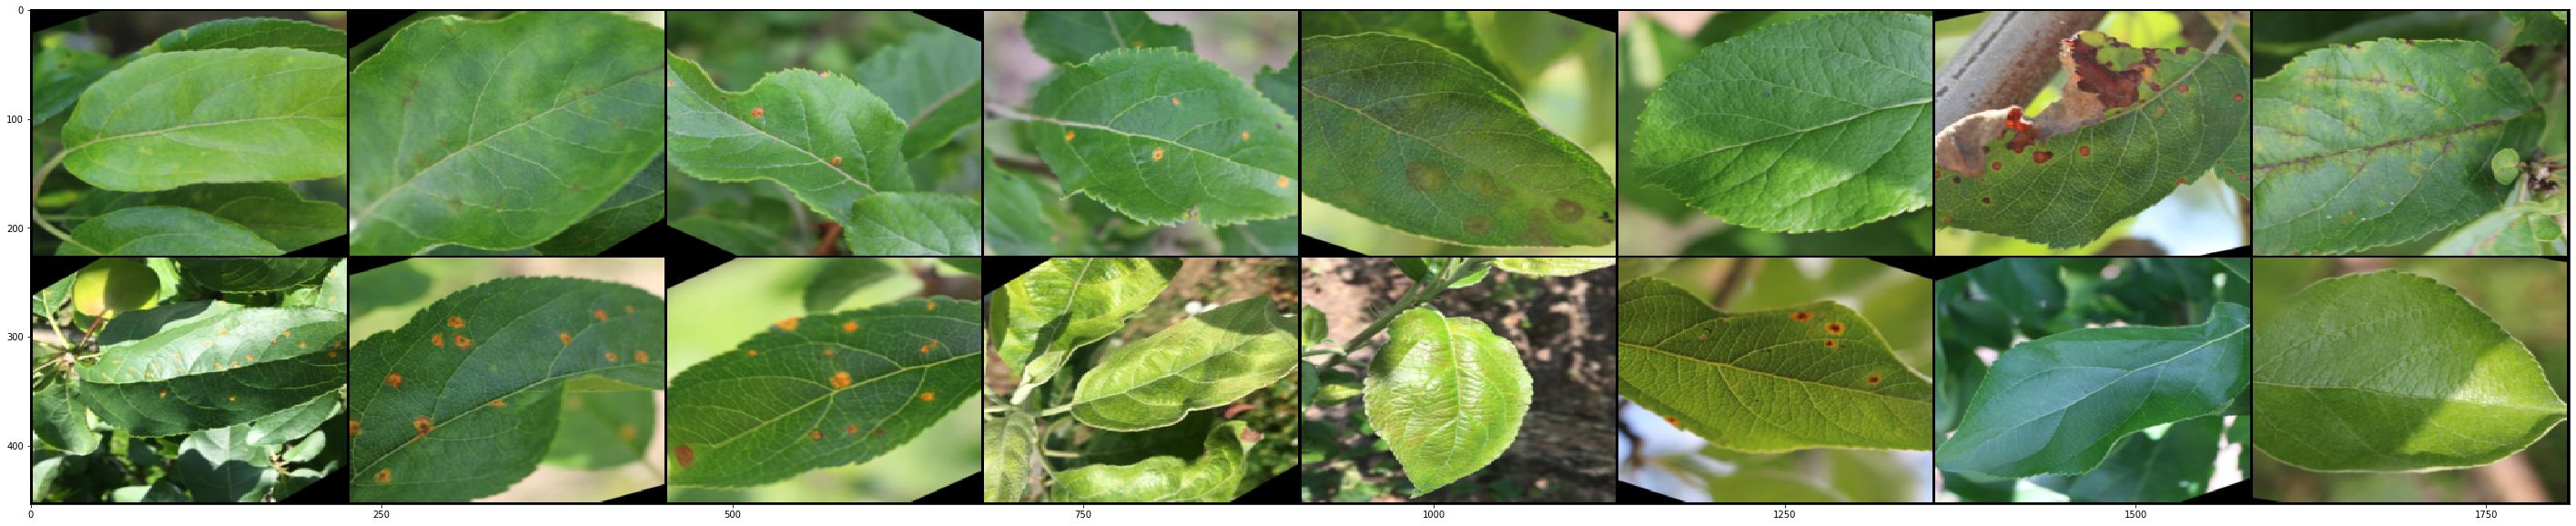

<Figure size 432x288 with 0 Axes>

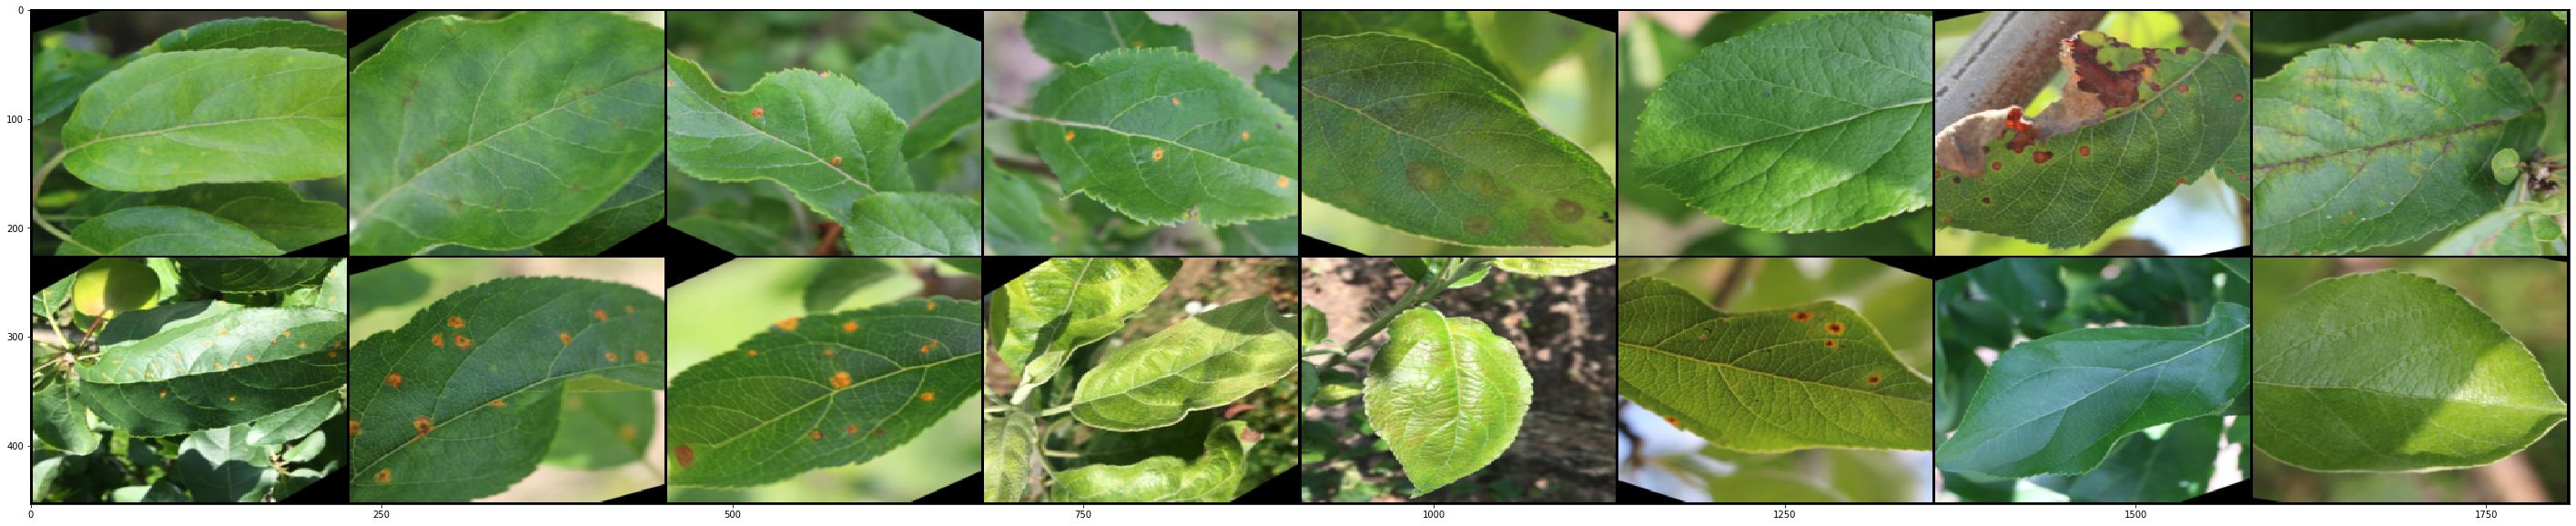

In [86]:
classes = ('healthy', 'multiple_diseases', 'rust', 'scab')
dataiter_test = iter(data_loader['train'])
#print('data_iter\n',dataiter_test)
images_test = dataiter_test.next()
images_test_data = images_test[0]
#print('image test data',images_test_data)
images_test_label = images_test[1]
print(len(images_test_label))

for i in range(len(images_test_label)):
    print(classes[images_test_label[i].numpy()])

def imshow(img):
    # image from transform
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure()
    fig = plt.figure(figsize=(50,10))
    ax_show = fig.add_subplot(111)
    ax_show.imshow(np.transpose(npimg, (1, 2, 0)), aspect = 'auto', interpolation='none')
    plt.show()
    
    # image unormalize
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure()
    fig = plt.figure(figsize=(50,10))
    ax_show = fig.add_subplot(111)
    ax_show.imshow(np.transpose(npimg, (1, 2, 0)), aspect = 'auto', interpolation='none')
    plt.show()

# print images
imshow(torchvision.utils.make_grid(images_test_data))

# Model

In [87]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # CL sees 224 x 224 x 3 image tensor
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv11= nn.Conv2d(16, 16, 2, padding=0)
        self.conv1_1 = nn.Conv2d(16, 32, 3, padding=1)
        
        # CL sees 112 x 112 x 16
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv22 = nn.Conv2d(64, 64, 2, padding=0)
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        
        
        # CL sees 56 x 56 x 32
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv33 = nn.Conv2d(256, 256, 2, padding=0)
        self.conv3_1 = nn.Conv2d(256, 512, 3, padding=1)
        
        
        # CL sees 56 x 56 x 32
        #self.conv4 = nn.Conv2d(256, 512, 2, padding=0)
        #self.conv4_1 = nn.Conv2d(512, 512, 3, padding=1)
        #self.batchnorm512 = nn.BatchNorm2d(512)
        
        #batchNorm
        self.batchnorm16 = nn.BatchNorm2d(16)
        self.batchnorm32 = nn.BatchNorm2d(32)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.batchnorm256 = nn.BatchNorm2d(256)
        self.batchnorm512 = nn.BatchNorm2d(512)
        self.batchnorm1024 = nn.BatchNorm2d(1024)
        self.batchnorm2048 = nn.BatchNorm2d(2048)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(3, 3)
        self.AVGpool = nn.AvgPool2d(3, 3)
        
        # linear layer (64 * 28 * 28 -> 500)
        self.fc1 = nn.Linear(512 * 7 * 7, 500)
        
        # linear layer (500 -> 250)
        self.fc2 = nn.Linear(500, 250)
        
        # linear layer (250 -> 125)
        self.fc3 = nn.Linear(250, 125)
        
        # linear layer (125 -> 4)
        self.fc4 = nn.Linear(125, 4)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout2d(0.2)
        
        # LogSoftmax
        self.LogSM = nn.LogSoftmax()
    
    def forward(self, x):
        ## Define forward behavior
        # 1st CNN
        # 3 => 16
        x = self.conv1(x)
        x = F.relu6(x)
        x = self.conv11(x)
        x = F.relu6(x)
        x = self.batchnorm16(x)
        
        # 16 => 32
        x = self.conv1_1(x)
        x = F.relu6(x)
        x = self.batchnorm32(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 2nd CNN
        # 32 => 64
        x = self.conv2(x)
        x = F.relu6(x)
        x = self.conv22(x)
        x = F.relu6(x)
        x = self.batchnorm64(x)
        
        # 64 => 128
        x = self.conv2_1(x)
        x = F.relu6(x)
        x = self.batchnorm128(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        # 3rd CNN
        # 128 => 256
        x = self.conv3(x)
        x = F.relu6(x)
        x = self.conv33(x)
        x = F.relu6(x)
        x = self.batchnorm256(x)

        # 256 => 512
        x = self.conv3_1(x)
        x = F.relu6(x)
        x = self.batchnorm512(x)
        
        x = self.AVGpool(x)
        x = self.dropout(x)
        
        
        #print(x.shape)
        # flatten image input
        #print(x.shape)
        x = x.view(-1, 512 * 7 * 7)
        #x = self.dropout(x)
        
        # add 1st hidden layer, with relu activation function
        x = self.fc1(x)
        x = F.relu6(x)
        x = self.dropout(x)
        
        #h2
        x = self.fc2(x)
        x = F.relu6(x)
        x = self.dropout(x)
        
        #h3
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        #h
        x = self.LogSM(self.fc4(x))

        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_patho = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

    
model_patho = Net()

In [88]:
summary(Net(),input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
            Conv2d-2         [-1, 16, 223, 223]           1,040
       BatchNorm2d-3         [-1, 16, 223, 223]              32
            Conv2d-4         [-1, 32, 223, 223]           4,640
       BatchNorm2d-5         [-1, 32, 223, 223]              64
         AvgPool2d-6           [-1, 32, 74, 74]               0
         Dropout2d-7           [-1, 32, 74, 74]               0
            Conv2d-8           [-1, 64, 74, 74]          18,496
            Conv2d-9           [-1, 64, 73, 73]          16,448
      BatchNorm2d-10           [-1, 64, 73, 73]             128
           Conv2d-11          [-1, 128, 73, 73]          73,856
      BatchNorm2d-12          [-1, 128, 73, 73]             256
        AvgPool2d-13          [-1, 128, 24, 24]               0
        Dropout2d-14          [-1, 128,

C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:134: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [89]:
### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = optim.SGD(model_patho.parameters(), lr=0.0005)

In [92]:
def train(n_epochs, loaders, model, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for idx, (data, target) in enumerate(loaders['train']):

            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            #update training loss
            train_loss += loss.item()*data.size(0)
            
        model.eval()
        for idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss,
            torch.save(model.state_dict(), 'model_patho_16_valid_LR00005.pt'))
                 )
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [91]:
model_res = train(30, data_loader, model_patho, optimizer, criterion)



C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:134: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 1.383682 	Validation Loss: 1.380209
Validation loss decreased (inf --> 1.380209).  Saving model ...
Epoch: 2 	Training Loss: 1.376397 	Validation Loss: 1.373516
Validation loss decreased (1.380209 --> 1.373516).  Saving model ...
Epoch: 3 	Training Loss: 1.372505 	Validation Loss: 1.367329
Validation loss decreased (1.373516 --> 1.367329).  Saving model ...
Epoch: 4 	Training Loss: 1.365278 	Validation Loss: 1.360895
Validation loss decreased (1.367329 --> 1.360895).  Saving model ...
Epoch: 5 	Training Loss: 1.358889 	Validation Loss: 1.353848
Validation loss decreased (1.360895 --> 1.353848).  Saving model ...
Epoch: 6 	Training Loss: 1.351489 	Validation Loss: 1.347675
Validation loss decreased (1.353848 --> 1.347675).  Saving model ...
Epoch: 7 	Training Loss: 1.344125 	Validation Loss: 1.341245
Validation loss decreased (1.347675 --> 1.341245).  Saving model ...
Epoch: 8 	Training Loss: 1.340804 	Validation Loss: 1.334316
Validation loss decreased (1.34124

In [94]:
model_res = Net()

# load the model that got the best validation accuracy
model_res.load_state_dict(torch.load('model_patho_16_valid_LR00005.pt'))

<All keys matched successfully>

# TEST

In [95]:
class CustomDataset_test(Dataset):
    def __init__(self, csv_file, id_col, target_col, root_dir, sufix=None, transform=None):
        """
        Args:
            csv_file   (string):             Path to the csv file with annotations.
            root_dir   (string):             Directory with all the images.
            id_col     (string):             csv id column name.
            target_col (string):             csv target column name.
            sufix      (string, optional):   Optional sufix for samples.
            transform  (callable, optional): Optional transform to be applied on a sample.
        """
        self.data      = pd.read_csv(csv_file)
        self.id        = id_col
        self.target    = target_col
        self.root      = root_dir
        self.sufix     = sufix
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get the image name at the different idx
        img_name = self.data.loc[idx, self.id]
        
        # if there is not sufic, nothing happened. in this case sufix is '.jpg'
        if self.sufix is not None:
            img_name = img_name + self.sufix
        
        # it opens the image of the img_name at the specific idx
        image = Image.open(os.path.join(self.root, img_name))
        
        # if there is not transform nothing happens, here we defined below two transforms for train and for test
        if self.transform is not None:
            image = self.transform(image)
        
        label = self.data.loc[idx, self.id]
        label = int(label[5:])
        label = torch.tensor(label)
        
        return image, label

data_transforms_test = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

params = {
    'id_col':     'image_id',  
    'target_col': ['healthy', 'multiple_diseases', 'rust', 'scab'],
    'sufix':      '.jpg',
    'transform':  data_transforms_test['test']
}

test_dataset = CustomDataset_test(csv_file=data_dir+'test.csv', root_dir=data_dir+'images', **params)
test_loader = DataLoader(test_dataset, batch_size = 4, shuffle=True)

In [96]:
print('TRAINING')
img_test, lab_test = test_dataset.__getitem__(0)

print('DATASET TEST')
print('image at the first row: {}', img_test.shape)
print('image size at the first row: {}'.format(img_test.size()))
print('Lab at the first row: ', lab_test)
print('lab format at the first row: {}'.format(lab_test))
print('lab format at the first row: {}'.format(lab_test.shape))

print()
print('Train Loader type')
test_iter = iter(test_loader)
print(type(test_iter))


images_test, labels_test = train_iter.next()
print()
print('DATALOADER TEST')
print('images test',images_test[0][0][0][0])
print('images type on batch size = {}'.format(type(images_test)))
print('images shape on batch size = {}', images_test.shape)
print('labels type on batch size = {}'.format(type(labels_test)))
print('labels shape on batch size = {}', labels_test)

TRAINING
DATASET TEST
image at the first row: {} torch.Size([3, 224, 224])
image size at the first row: torch.Size([3, 224, 224])
Lab at the first row:  tensor(0)
lab format at the first row: 0
lab format at the first row: torch.Size([])

Train Loader type
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>

DATALOADER TEST
images test tensor(0.2941)
images type on batch size = <class 'torch.Tensor'>
images shape on batch size = {} torch.Size([16, 3, 224, 224])
labels type on batch size = <class 'torch.Tensor'>
labels shape on batch size = {} tensor([0, 2, 2, 2, 2, 3, 0, 2, 3, 3, 1, 0, 0, 2, 3, 0])


data_iter
image test data tensor([[[[0.6392, 0.6667, 0.6863,  ..., 0.4941, 0.4784, 0.5059],
          [0.6824, 0.7020, 0.7216,  ..., 0.4471, 0.4431, 0.4824],
          [0.6863, 0.7176, 0.7412,  ..., 0.4392, 0.4235, 0.4549],
          ...,
          [0.4275, 0.4667, 0.5020,  ..., 0.6510, 0.6863, 0.6784],
          [0.3647, 0.4078, 0.4510,  ..., 0.6588, 0.7020, 0.6824],
          [0.3294, 0.3686, 0.4275,  ..., 0.6745, 0.7020, 0.6667]],

         [[0.6588, 0.6824, 0.7020,  ..., 0.5373, 0.5333, 0.5608],
          [0.7020, 0.7216, 0.7412,  ..., 0.4941, 0.4980, 0.5255],
          [0.7137, 0.7412, 0.7647,  ..., 0.4784, 0.4706, 0.5020],
          ...,
          [0.2039, 0.1882, 0.1765,  ..., 0.6549, 0.6902, 0.6863],
          [0.2078, 0.2000, 0.1882,  ..., 0.6627, 0.7059, 0.6902],
          [0.2039, 0.2039, 0.1882,  ..., 0.6745, 0.7020, 0.6706]],

         [[0.4863, 0.4941, 0.5098,  ..., 0.5255, 0.5294, 0.5490],
          [0.5294, 0.5137, 0.5294,  ..., 0.4549, 0.4667, 0.5176],
          [0.541

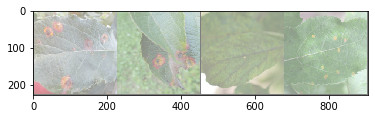

In [97]:
classes = ('healthy', 'multiple_diseases', 'rust', 'scab')

dataiter_test = iter(test_loader)
print('data_iter\n',dataiter_test)
images_test = dataiter_test.next()
images_test_data = images_test[0]
print('image test data',images_test_data)
images_test_label = images_test[1]
print(images_test_label)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# print images
imshow(torchvision.utils.make_grid(images_test_data))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [101]:
model_test = Net()
model_test.load_state_dict(torch.load('model_patho_16_valid_LR00005.pt'))
model_test = model_test.eval()

out_fwd = model_test.forward(images_test_data)
print('Result preditcion model on dataset:\n {}\n'.format(out_fwd))
probs = torch.exp(out_fwd)
print('probs\n', probs)
top_probs, top_labs = probs.topk(4)
print('top_probs:\n {} \n top_labs:\n {}'.format(top_probs, top_labs))
print(classes[top_labs[0][0].detach().numpy()])
print(classes[top_labs[1][0].detach().numpy()])
print(classes[top_labs[2][0].detach().numpy()])
print(classes[top_labs[3][0].detach().numpy()])


C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:134: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Result preditcion model on dataset:
 tensor([[-1.8744, -2.6946, -1.2668, -0.6986],
        [-1.8156, -2.5141, -1.2370, -0.7634],
        [-2.5643, -3.6341, -1.4930, -0.3976],
        [-1.3025, -2.0129, -1.2059, -1.2204]], grad_fn=<LogSoftmaxBackward>)

probs
 tensor([[0.1534, 0.0676, 0.2817, 0.4973],
        [0.1627, 0.0809, 0.2903, 0.4661],
        [0.0770, 0.0264, 0.2247, 0.6719],
        [0.2718, 0.1336, 0.2994, 0.2951]], grad_fn=<ExpBackward>)
top_probs:
 tensor([[0.4973, 0.2817, 0.1534, 0.0676],
        [0.4661, 0.2903, 0.1627, 0.0809],
        [0.6719, 0.2247, 0.0770, 0.0264],
        [0.2994, 0.2951, 0.2718, 0.1336]], grad_fn=<TopkBackward>) 
 top_labs:
 tensor([[3, 2, 0, 1],
        [3, 2, 0, 1],
        [3, 2, 0, 1],
        [2, 3, 0, 1]])
scab
scab
scab
rust


# Submission

In [102]:
submission_df = pd.read_csv(data_dir + 'sample_submission.csv')

submission_df.iloc[:, 1:] = 0

submission_df.head()

image_id  healthy  multiple_diseases  rust  scab
0   Test_0        0                  0     0     0
1   Test_1        0                  0     0     0
2   Test_2        0                  0     0     0
3   Test_3        0                  0     0     0
4   Test_4        0                  0     0     0

In [104]:
submission_df_test = pd.read_csv(data_dir + 'sample_submission.csv')

model_test = Net()
model_test.load_state_dict(torch.load('model_patho_16_valid_LR00005.pt'))
model_test = model_test.eval()

batch_size = 4

for data in enumerate(test_loader):
    images_data = data[1][0]
    #print(images_data)
    label_data = data[1][1]
    #print(label_data)   
    probs = torch.exp(model_test(images_data))
    #print(probs)
    label_data = label_data.numpy()
    #print(label_data)
    probs = probs.detach().numpy()
    #print(probs)
    for i in range(len(label_data)):
        #print(i)
        ind = label_data[i]
        #print(ind)
        res_probs = probs[i]
        #print(res_probs)
        res_add = ['Test_'+str(ind), res_probs[0], res_probs[1],res_probs[2],res_probs[3]]
        submission_df_test.loc[ind] = res_add         
        
pd.set_option("display.max_rows", 10, "display.max_columns", None)
print(submission_df_test)
submission_df_test.to_csv(path_or_buf='sample_submission_model_patho_16_valid_LR00005.csv', index=False)


C:\Users\amallet\Anaconda\envs\udacity_env\lib\site-packages\ipykernel_launcher.py:134: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


       image_id   healthy  multiple_diseases      rust      scab
0        Test_0  0.184770           0.097004  0.316655  0.401570
1        Test_1  0.221127           0.131371  0.316104  0.331398
2        Test_2  0.153423           0.072616  0.286575  0.487387
3        Test_3  0.314557           0.124962  0.279342  0.281139
4        Test_4  0.231136           0.137820  0.309195  0.321849
...         ...       ...                ...       ...       ...
1816  Test_1816  0.102910           0.041680  0.255788  0.599623
1817  Test_1817  0.185877           0.088123  0.272115  0.453886
1818  Test_1818  0.257045           0.119031  0.275428  0.348497
1819  Test_1819  0.178812           0.082847  0.287536  0.450805
1820  Test_1820  0.317917           0.137582  0.310071  0.234429

[1821 rows x 5 columns]
